# Eigenbeat

Exploration by Andy Yan

## Purpose

The purpose of this notebook is to explore the usage of PCA, Principal Component Analysis, to construct a tune using the eigenvectors of hip-hop drum tracks taken from: https://www.looperman.com/loops?page=1&cid=1&gid=7&ftempo=115&ttempo=130&order=date&dir=d.

## Background

PCA is a useful tool that can be applied for facial recognition purposes. The central idea goes as follows: given a set of data points in some n-dimentional space, we attempt to find the direction of the vector that either

1. Minimizes the size of the orthogonal projection of each datapoint onto the vector.
2. Maximizes the variance of the distance between the points of the orthogonal projection and the origin.

The intuition behind this is to find a vector that captures the variance of the data the best. You can read more here: http://cs229.stanford.edu/notes/cs229-notes10.pdf.

In order to use this concept in facial recognition, imagine each data point represents a face. For example, a data point, x, could represent the grayscale values of every pixel in an image, where $x_1$ is the grayscale value of the first pixel, $x_2$ is the grayscale value of the second pixel, etc.

Next, assume we have found a vector that best captures the variance of the data set, which has 4 data points or 4 faces.
<img src="img/pca.png" width="400px">
Given the directionality of the vector, imagine we have to compare the similarity between two faces. In order to do this, we find the distance of the points between the orthogonal projection of the two faces onto the vector instead of finding the distance between the data points directly. By doing this, we are essentially stating that the difference between two faces is not the difference in every pixel but rather the difference in some principal component represented by the vector. Therefore, random differences are not taken into account such as lighting if the principal component captured represents details of the face rather than details of the photo.

To get the principle vector, we simply get the eigenvector with the largest eigenvalue of the covariance matrix of the data set. There is a proof to justify this, but the intuition is that the eigenvector with the largest eigenvalue of the covariance matrix is the direction that has the maximum variance in the data set.

<img src="img/eigenface.png" width="300px">
If we reconstruct an image using a point that sits on the vector, we extract what is called an eigenface, which as shown above, has the basic shape of a human.

## Idea

Given the ability to construct a figure that captures the structure of a human face in images (the eigenface), can we apply this idea to music, constructing a sort of beat that captures the basic structure of a song? Specifically, I limit the scope of song to just be hip-hop drum tracks with BPM between 115 and 130 to try to capture the structure of a hip hop song.

In [208]:
import numpy as np
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
import os
import IPython.display as ipd
from scipy.signal import lfilter
from sklearn import decomposition

SECONDS_PER_SAMPLE = 1200 * 16/7500 #The amount of seconds to excerpt from a song.
SAMPLING_RATE = 44100

## Data Pre-processing

First, we convert all audio files to floating point arrays representing amplitude of samples sampled at the rate of 44100Hz.

In [194]:
samples = []

for filename in os.listdir('data'):
    if ".wav" in filename:
        a = wavfile.read("data/" + filename)
        assert(a[0] == SAMPLING_RATE)
        plt.show()
        i = 0
        while i < len(a[1]) - SAMPLING_RATE*SECONDS_PER_SAMPLE:
            samples.append(np.array(a[1], dtype=float)[round(i):round(i+SAMPLING_RATE*SECONDS_PER_SAMPLE), 0])
            i += SAMPLING_RATE*SECONDS_PER_SAMPLE

samples = np.array(samples)
print(samples.shape)

/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


(96, 112896)


Here are the some of the samples, which are 2 second clips of the audio files in the soundtracks/ folder.

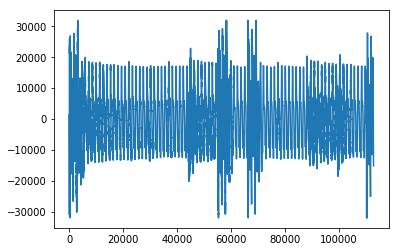

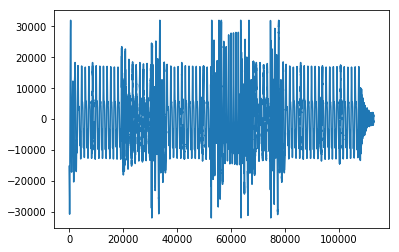

In [195]:
plt.plot(samples[0])
plt.show()
plt.plot(samples[1])
plt.show()

In order to evaluate the lossiness of representing the data in this format, we can reconstruct the processed vectors into wav files and compare it to the original by ear.

In [196]:
ipd.Audio('data/1.wav')

In [197]:
wavfile.write('generated/sample.wav', SAMPLING_RATE, np.asarray(samples[1], dtype=np.int16))
ipd.Audio('generated/sample.wav')

Generally, we would normalize the data by setting the mean of the data to be 0 and setting the covariance to 1 before using PCA.

This ensures that our eigenvectors can represent the appropriate shape of our data and to prevent certain features to be treated at different scales.

However, because we are analyzing audio files, the mean is supposed to be 0 to begin with, so we can skip that step. We can also skip the step of setting the covariance to 1 since the all samples of audio files in our data are on the same scale.

## Optional Preprocessing

We can trim the audio clips because some of them are different lengths.

Because the track is mostly bass dominant tracks after the first round of experimentations, we can try to equalize the amplitude between different tracks by artificially scaling each track to have a max amplitude of 30000.

We can also subtract the mean wave to experiment.

In [198]:
trimmed = []
for i in range(len(samples)):
    trimmed.append(samples[i][:])

In [199]:
scaled_between_tracks = []
for i in range(len(trimmed)):
    scaled_between_tracks.append(trimmed[i]/max(samples[i]) * 30000)
    
scaled_between_tracks = np.array(scaled_between_tracks)

In [200]:
mean_scaled_between_tracks = scaled_between_tracks - np.apply_along_axis(np.mean, 0, scaled_between_tracks)

## PCA Modeling

In [201]:
def get_eigenval(singular_val):
    return singular_val**2 / samples.shape[0]

In [202]:
pca = decomposition.PCA(n_components=3)

In [203]:
pca.fit(mean_scaled_between_tracks)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

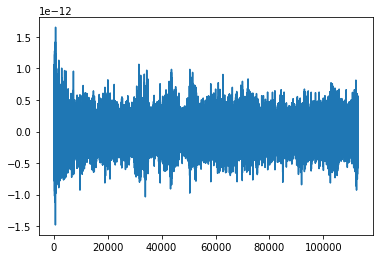

In [204]:
plt.plot(pca.mean_)
plt.show()
wavfile.write('generated/avg.wav', SAMPLING_RATE, np.asarray(pca.mean_, dtype=np.int16))
ipd.Audio('generated/avg.wav')

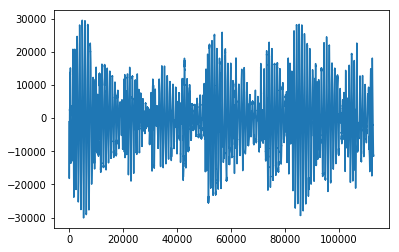

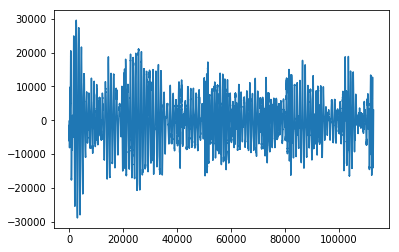

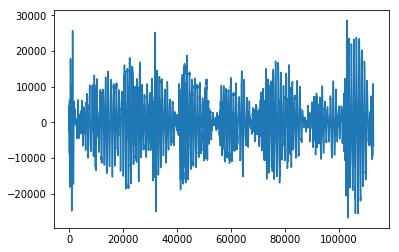

In [205]:
from functools import reduce
for i in range(len(pca.components_)):
    arr = pca.components_[i] * pca.singular_values_[i]
    vals = np.asarray(arr/max(arr) * 30000, dtype=np.int16)
    
    n = 15  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    yy = lfilter(b,a,vals)
    vals = yy
    
    plt.plot(vals)
    plt.show()
    wavfile.write('generated/eigen' + str(i) + '.wav', SAMPLING_RATE, np.asarray(np.concatenate([vals, vals, vals, vals]), dtype=np.int16))

In [206]:
ipd.Audio('generated/eigen0.wav')

In [207]:
ipd.Audio('generated/eigen1.wav')

In [190]:
ipd.Audio('generated/eigen2.wav')